In [1]:
# Author: Connor Ludwig
# Organization: Bintu Lab, Stanford University
# Date: 11/17/2021

import sys
import os
import numpy as np
import matplotlib
# matplotlib.use('pdf') # do this because environment does not have GUI backend
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from scipy.special import factorial
import seaborn as sns
import pandas as pd
import re
import statistics
from scipy import stats
import math
import mpl_axes_aligner

font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

# !{sys.executable} -m pip install goenrichment

# specify list of tile sequences and an amount of buffer from the end for substring matching (integer value)
def mergeTiles(tileList, buffer):
    # iterate over tile sequences
    for t in range(len(tileList)-1):
        i = 0
        # while the next tile does NOT start with a substring of the first tile (slicing from the end), increment counter
        # if it does, exit while loop with counter value
        while not tileList[t+1].startswith(tileList[t][i:]):
            i += 1
            # if slicing too close to end of sequence, exit loop to avoid incorrect stitching by chance
            if i == (len(tileList[t]) - buffer):
                break
        # as long as counter value has not reached the maximum value (sequence length minus buffer length)
        if i != (len(tileList[t]) - buffer):
            # set merged sequence as the unique substring of the first tile plus the full sequence of the next tile
            out = tileList[t][:i] + tileList[t+1]
            # re-define tileList, adding merged sequence in place of the constituent sequences
            tileList = tileList[:t] + [out] + tileList[t+2:]
            # use recursion to merge consecutive overlapping tiles
            return mergeTiles(tileList, buffer)
    # return edited tileList
    return tileList

# The following three scripts are from https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

print('Packages imported and functions defined')

Packages imported and functions defined


#### Quantify number of total WT/perturbations and tiles subjected to chemical inhibition for Fig. 5A

In [80]:
oligos = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV_Hits_DMS_codon-opt-proteins_oligos.csv')
oligos_DMS = oligos[(oligos['Oligo ID'].str.contains('DMS')) & (~oligos['Oligo ID'].str.contains('random|fiducial'))]
oligos_WT = oligos_DMS[oligos_DMS['Oligo ID'].str.contains('WT')]
oligos_mut = oligos_DMS[~oligos_DMS['Oligo ID'].str.contains('WT')]

print('Number of WT sequences perturbed:', len(oligos_WT))
print('Number of perturbations:', len(oligos_mut))

hittiles = pd.read_csv('../Supplemental Tables - CSV/HHVhits_added-info.csv')
hittiles = hittiles[~hittiles['Oligo ID'].str.contains('random|fiducial')]
print('Number of hit tiles designed for screening with chemical inhibitors:', len(hittiles))

Number of WT sequences perturbed: 98
Number of perturbations: 7696
Number of hit tiles designed for screening with chemical inhibitors: 821


### Sequence Analyses

In [2]:
# read in dataframe and re-structure for plotting, etc.
df = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_ActivD2-ReprD5_detailed.csv')
dfA = df[df['Screen']=='Activation']
dfA = dfA[['Oligo ID', 'Avg', 'Net Charge', 'Duplicate', 'Tile Sequence']]
dfA = dfA.rename(columns={'Avg':'Activation'})
dfR = df[df['Screen']=='Repression']
dfR = dfR[['Oligo ID', 'Avg', 'Net Charge', 'Duplicate', 'Tile Sequence']]
dfR = dfR.rename(columns={'Avg':'Repression'})
df = pd.merge(left=dfA, right=dfR, on=['Oligo ID', 'Net Charge', 'Duplicate', 'Tile Sequence'], how='inner')

cutoffA = 1.0846347878236864
cutoffR = 0.6987727639587653
    
print('Complete')

Complete


### Charge vs Hydrophobicity

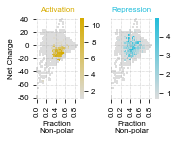

In [3]:
def hex2rgb(hexadecimal):
    hexadecimal = hexadecimal.lstrip('#')
    rgb = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
    return rgb

def charge_hydrophobicity(df, cutoffA, cutoffR, screenType):
    to_exclude = ['P03495', 'P05949', 'P69699', 'K9N4V0', 'K9N643', 'P04608', 'P22363', 'P03129',
                  'P06463', 'P0C0U1', 'P16494', 'P30927', 'P0DOE9', 'P04601', 'P20639', 'P0A015',
                  'P01876', 'P02768', 'P22629', 'P0DPH7', 'P03081', 'P63000', 'Q92558', 'P42768',
                  'P03247', 'P98170', 'Q07817', 'O75324', 'random', 'fiducial']
    df = df[~df['Oligo ID'].str.contains('|'.join(to_exclude))]
    
    oligos = list(df['Oligo ID'])
    activscores = list(df['Activation'])
    charges = list(df['Net Charge'])
    seqs = list(df['Tile Sequence'])
    reprscores = list(df['Repression'])

    residueList = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

    oligos_new = []
    activscores_new = []
    charges_new = []
    seqs_new = []
    reprscores_new = []
    residue = []
    frequency = []

    for i in range(len(oligos)):
        for aa in residueList:
            oligos_new.append(oligos[i])
            activscores_new.append(activscores[i])
            charges_new.append(charges[i])
            seqs_new.append(seqs[i])
            reprscores_new.append(reprscores[i])
            residue.append(aa)
            frequency.append(seqs[i].count(aa)/len(seqs[i]))

    df = pd.DataFrame({'Oligo ID':oligos_new,
                       'Sequence':seqs_new,
                       'Net Charge':charges_new,
                       'Activation':activscores_new,
                       'Repression':reprscores_new,
                       'Residue':residue,
                       'Frequency':frequency})

    # Soto methods excludes valine, but calculation of the score includes valine - confirmed 1/16/2022
    hydroDict = {'A':1, 'C':0, 'D':0, 'E':0, 'F':1, 'G':0, 'H':0, 'I':1, 'K':0, 'L':1,
                 'M':1, 'N':0, 'P':1, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':1, 'W':1, 'Y':1}

    df['Hydrophobicity Value'] = df['Residue'].map(hydroDict)
    df['Hydrophobic Content'] = df['Frequency'] * df['Hydrophobicity Value']

#     cutoffA = round(1.7315260717976442, 3)
#     cutoffR = round(0.8850726544786016, 3)
    df['Activ Hit'] = np.where(df['Activation'] >= cutoffA, 1, 0)
    df['Repr Hit'] = np.where(df['Repression'] >= cutoffR, 1, 0)

    dfg = df.groupby(by=['Oligo ID', 'Sequence', 'Net Charge', 'Activation', 'Repression', 'Activ Hit', 'Repr Hit']).sum().reset_index()
    charges = [y/2 for y in range(-160,81,5)]
    hydroph = [x/200 for x in range(0,171,5)]
    
    dfg = dfg.assign(charge_cut = pd.cut(dfg['Net Charge'], len(charges), labels=charges),
                     hydrophobicity_cut = pd.cut(dfg['Hydrophobic Content'], len(hydroph), labels=hydroph))
    dfg = dfg[['charge_cut', 'hydrophobicity_cut', screenType]]
    dfg = dfg.groupby(by=['charge_cut', 'hydrophobicity_cut']).max().reset_index()
   
    dfg_row = list(set(list(dfg['charge_cut'])))
    dfg_row.sort()
    dfg_row = dfg_row[::-1]
    
    dfg_col = list(set(list(dfg['hydrophobicity_cut'])))
    dfg_col.sort()
    
    df_mat = pd.DataFrame(index=dfg_row, columns=dfg_col)
    for c in dfg_col:
        for r in dfg_row:
            df_mat.loc[r][c] = list(dfg[(dfg['charge_cut']==r) & (dfg['hydrophobicity_cut']==c)][screenType])[0]
            
    return df_mat, charges #, cutoffA, cutoffR

# df = df[(df['Activation']>=cutoffA) & (df['Repression']>=cutoffR)]

matA, chargesA = charge_hydrophobicity(df, cutoffA, cutoffR, 'Activation')
colorA = get_continuous_cmap(['#DDDDDD', '#D7AC00'])

matR, chargesR = charge_hydrophobicity(df, cutoffA, cutoffR, 'Repression')
colorR = get_continuous_cmap(['#DDDDDD', '#23BEDB'])

xpos = [0.5, 8.5, 16.5, 24.5, 32.5]
xticks = [0.0, 0.2, 0.4, 0.6, 0.8]
ypos = [y + 0.5 for y in range(0, 49, 8)]
yticks = [40, 20, 0, -20, -40, -60, -80]

fig, ax = plt.subplots(1, 2, figsize=(2.5, 2))
sns.heatmap(matA.fillna(np.nan), vmin=cutoffA, cmap=colorA, ax=ax[0])
ax[0].set_xticks(xpos)
ax[0].set_xticklabels(xticks)
ax[0].set_yticks(ypos)
ax[0].set_yticklabels(yticks)
ax[0].set_ylabel('Net Charge')
ax[0].set_xlabel('Fraction\nNon-polar')
ax[0].set_title('Activation', fontsize=8, color='#D7AC00')

sns.heatmap(matR.fillna(np.nan), vmin=cutoffR, cmap=colorR, ax=ax[1])
ax[1].set_xticks(xpos)
ax[1].set_xticklabels(xticks)
ax[1].set_yticks([])
ax[1].set_yticklabels(labels=[])
ax[1].set_xlabel('Fraction\nNon-polar')
ax[1].set_title('Repression', fontsize=8, color='#23BEDB')

for x in xpos:
    ax[0].axvline(x, ls=':', color='#999999', linewidth=0.5)
    ax[1].axvline(x, ls=':', color='#999999', linewidth=0.5)
for y in ypos:
    ax[0].axhline(y, ls=':', color='#999999', linewidth=0.5)
    ax[1].axhline(y, ls=':', color='#999999', linewidth=0.5)
    
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 5/net-charge_hydrophobicity.png', dpi=1200)


### Compositional Bias: Tile-level Analysis

The following takes the UniRef90 HHV entries (891 of them) and computes the amino acid frequencies for each virus' proteome. The results are plotted as a bar plot. Note that the following is not featured in a figure panel.

C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


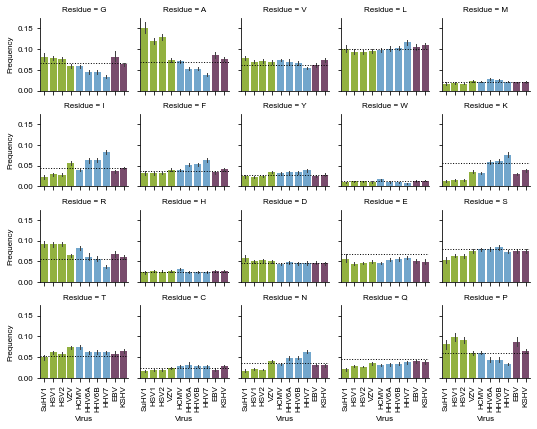

In [4]:
font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

uref = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/uniref_reviewed_HHV+SuHV.csv')
uref = uref.rename(columns={'Cluster ID':'UniProt ID'})
uIDmap = pd.read_csv('../Supplemental Tables - CSV/uID_protein_virus_mapping_HHV_expanded.csv')

ids = list(uref['UniProt ID'])
seqs = list(uref['Representative Sequence'])

ids2 = []
res = []
freq = []

for i, s in zip(ids, seqs):
    total = 0
    resDict = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 'H':0, 'I':0, 'K':0, 'L':0,
               'M':0, 'N':0, 'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 'W':0, 'Y':0}

    for aa in list(s):
        resDict[aa] += 1
        total += 1
        
    for k in resDict:
        ids2.append(i)
        res.append(k)
        freq.append(resDict[k]/total)
        
humanfreq = [6.60, 6.97, 6.08, 10.02, 2.21, 4.42, 3.79, 2.74, 1.32, 5.62,
             5.68, 2.59, 4.70, 6.84, 8.10, 5.31, 2.31, 3.60, 4.64, 6.11]   
humanfreq = [h/100 for h in humanfreq]

freqdf = pd.DataFrame({'UniProt ID':ids2, 'Residue':res, 'Frequency':freq})
freqdf = pd.merge(freqdf, uIDmap, on='UniProt ID', how='left')

virus = list(set(list(freqdf['Virus'])))
residue = list(set(list(freqdf['Residue'])))
resorder = ['G', 'A', 'V', 'L', 'M', 'I', 'F', 'Y', 'W', 'K', 'R', 'H', 'D', 'E', 'S', 'T', 'C', 'N', 'Q', 'P']
family = {'SuHV1':'alpha', 'HSV1':'alpha', 'HSV2':'alpha', 'VZV':'alpha', 'HCMV':'beta', 'HHV6A':'beta', 'HHV6B':'beta', 'HHV7':'beta', 'EBV':'gamma', 'KSHV':'gamma'}

freqdf = freqdf[~freqdf['Virus'].str.contains('CeHV')]
freqdf['Virus'] = pd.Categorical(freqdf['Virus'], categories=['SuHV1', 'HSV1', 'HSV2', 'VZV', 'HCMV', 'HHV6A', 'HHV6B', 'HHV7', 'EBV', 'KSHV'], ordered=True)
freqdf['Residue'] = pd.Categorical(freqdf['Residue'], categories=resorder, ordered=True)
freqdf = freqdf.sort_values(by=['Residue', 'Virus'])
freqdf['Family'] = freqdf['Virus'].map(family)
# print(freqdf)

pal = sns.color_palette(['#9AC42D', '#63A8DB', '#804571'])
g = sns.FacetGrid(data=freqdf, col='Residue', hue='Family', col_wrap=5, palette=pal, aspect=1, height=1.5)
g.map(sns.barplot, 'Virus', 'Frequency', errwidth=1)
for ax, h in zip(g.axes.flatten(), humanfreq):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.axhline(y=h, ls=':', color='k', lw=1)
    
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHV_amino-acid_frequencies_by_virus.png', dpi=1200)

The following is a similar analysis, but computes these on all tiles comprising the proteome (more similar to hits)

In [5]:
# font = {'family' : 'Arial',
#         'size'   : 8}

# matplotlib.rc('font', **font)

# uref = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/uniref_reviewed_HHV+SuHV_all-tiles.csv')
# uref['UniProt ID'] = uref['Tile ID'].str.split('_').str[0]
# uIDmap = pd.read_csv('../Supplemental Tables - CSV/uID_protein_virus_mapping_HHV_expanded.csv')

# ids = list(uref['UniProt ID'])
# seqs = list(uref['Tile Sequence'])

# ids2 = []
# res = []
# freq = []

# for i, s in zip(ids, seqs):
#     total = 0
#     resDict = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 'H':0, 'I':0, 'K':0, 'L':0,
#                'M':0, 'N':0, 'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 'W':0, 'Y':0}

#     for aa in list(s):
#         resDict[aa] += 1
#         total += 1
        
#     for k in resDict:
#         ids2.append(i)
#         res.append(k)
#         freq.append(resDict[k]/total)
        
# humanfreq = [6.60, 6.97, 6.08, 10.02, 2.21, 4.42, 3.79, 2.74, 1.32, 5.62,
#              5.68, 2.59, 4.70, 6.84, 8.10, 5.31, 2.31, 3.60, 4.64, 6.11]   
# humanfreq = [h/100 for h in humanfreq]

# freqdf = pd.DataFrame({'UniProt ID':ids2, 'Residue':res, 'Frequency':freq})
# freqdf = pd.merge(freqdf, uIDmap, on='UniProt ID', how='left')

# virus = list(set(list(freqdf['Virus'])))
# residue = list(set(list(freqdf['Residue'])))
# resorder = ['G', 'A', 'V', 'L', 'M', 'I', 'F', 'Y', 'W', 'K', 'R', 'H', 'D', 'E', 'S', 'T', 'C', 'N', 'Q', 'P']
# family = {'SuHV1':'alpha', 'HSV1':'alpha', 'HSV2':'alpha', 'VZV':'alpha', 'HCMV':'beta', 'HHV6A':'beta', 'HHV6B':'beta', 'HHV7':'beta', 'EBV':'gamma', 'KSHV':'gamma'}

# freqdf = freqdf[~freqdf['Virus'].str.contains('CeHV')]
# freqdf['Virus'] = pd.Categorical(freqdf['Virus'], categories=['SuHV1', 'HSV1', 'HSV2', 'VZV', 'HCMV', 'HHV6A', 'HHV6B', 'HHV7', 'EBV', 'KSHV'], ordered=True)
# freqdf['Residue'] = pd.Categorical(freqdf['Residue'], categories=resorder, ordered=True)
# freqdf = freqdf.sort_values(by=['Residue', 'Virus'])
# freqdf['Family'] = freqdf['Virus'].map(family)
# # print(freqdf)

# pal = sns.color_palette(['#9AC42D', '#63A8DB', '#804571'])
# g = sns.FacetGrid(data=freqdf, col='Residue', hue='Family', col_wrap=5, palette=pal, aspect=1, height=1.5)
# g.map(sns.barplot, 'Virus', 'Frequency', errwidth=1)
# for ax, h in zip(g.axes.flatten(), humanfreq):
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#     ax.axhline(y=h, ls=':', color='k', lw=1)
    
# plt.tight_layout()
# plt.savefig('../Individual Figure Panels/Figure S5/HHV_amino-acid_frequencies_ALL-TILES_by_virus.png', dpi=1200)

The following takes all tiles from the HHV screen that are not immune, random, or fiducial controls and determines their amino acid compositions. Tiles are categorized by their effect activity (none, activation, repression, or dual) and binned by either virus species or family. The results are plotted as bar plots.

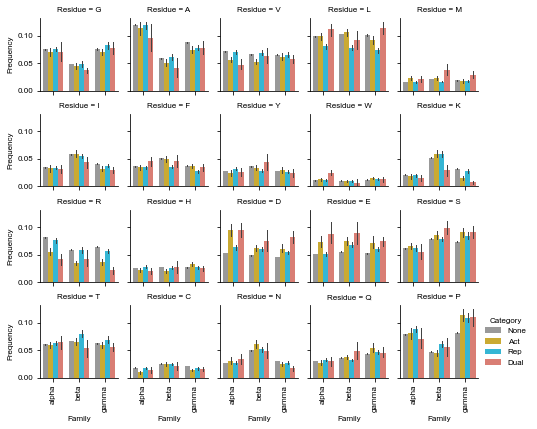

In [6]:
df2 = df.copy()
to_exclude = ['P03495', 'P05949', 'P69699', 'K9N4V0', 'K9N643', 'P04608', 'P22363', 'P03129',
                  'P06463', 'P0C0U1', 'P16494', 'P30927', 'P0DOE9', 'P04601', 'P20639', 'P0A015',
                  'P01876', 'P02768', 'P22629', 'P0DPH7', 'P03081', 'P63000', 'Q92558', 'P42768',
                  'P03247', 'P98170', 'Q07817', 'O75324', 'random', 'fiducial']
df2 = df2[~df['Oligo ID'].str.contains('|'.join(to_exclude))]
df2['Category'] = np.where(df2['Activation']>=cutoffA, 'Act', 'None')
df2['Category'] = np.where(df2['Repression']>=cutoffR, 'Rep', df2['Category'])
df2['Category'] = np.where((df2['Activation']>=cutoffA) & (df2['Repression']>=cutoffR), 'Dual', df2['Category'])
df2['UniProt ID'] = df['Oligo ID'].str.split('_').str[1]
df2 = pd.merge(df2, uIDmap, on='UniProt ID', how='left')

ids = list(df2['Oligo ID'])
seqs = list(df2['Tile Sequence'])
cats = list(df2['Category'])
virs = list(df2['Virus'])
acts = list(df2['Activation'])
reps = list(df2['Repression'])

ids2 = []
cats2 = []
virs2 = []
acts2 = []
reps2 = []
res = []
freq = []

for i, s, c, v, a, r in zip(ids, seqs, cats, virs, acts, reps):
    total = 0
    resDict = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 'H':0, 'I':0, 'K':0, 'L':0,
               'M':0, 'N':0, 'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 'W':0, 'Y':0}
    for aa in list(s):
        resDict[aa] += 1
        total += 1        
    for k in resDict:
        ids2.append(i)
        cats2.append(c)
        virs2.append(v)
        acts2.append(a)
        reps2.append(r)
        res.append(k)
        freq.append(resDict[k]/total)

tiledf = pd.DataFrame({'Oligo ID':ids2, 'Category':cats2, 'Virus':virs2, 'Activation':acts2,
                       'Repression':reps2, 'Residue':res, 'Frequency':freq})
tiledf['Virus'] = pd.Categorical(tiledf['Virus'], categories=['SuHV1', 'HSV1', 'HSV2', 'VZV', 'HCMV', 'HHV6A', 'HHV6B', 'HHV7', 'EBV', 'KSHV'], ordered=True)

resorder = ['G', 'A', 'V', 'L', 'M', 'I', 'F', 'Y', 'W', 'K', 'R', 'H', 'D', 'E', 'S', 'T', 'C', 'N', 'Q', 'P']
tiledf['Residue'] = pd.Categorical(tiledf['Residue'], categories=resorder, ordered=True)

tiledf['Category'] = pd.Categorical(tiledf['Category'], categories=['None', 'Act', 'Rep', 'Dual'])
tiledf = tiledf.sort_values(by=['Residue', 'Virus', 'Category'])
family = {'SuHV1':'alpha', 'HSV1':'alpha', 'HSV2':'alpha', 'VZV':'alpha', 'HCMV':'beta', 'HHV6A':'beta', 'HHV6B':'beta', 'HHV7':'beta', 'EBV':'gamma', 'KSHV':'gamma'}
tiledf['Family'] = tiledf['Virus'].map(family)

pal = sns.color_palette(['#999999', '#E3B919', '#1BC6EE', '#EA7063'])
g = sns.catplot(x='Virus', y='Frequency',
                hue='Category', col='Residue',
                data=tiledf, kind='bar', palette=pal,
                height=1.5, aspect=1.5, col_wrap=5, errwidth=1, legend=False)
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Category')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHV-hit-categories_amino-acid_frequencies_by_virus.png', dpi=1200)
plt.close()

h = sns.catplot(x='Family', y='Frequency',
                hue='Category', col='Residue',
                data=tiledf, kind='bar', palette=pal,
                height=1.5, aspect=1, col_wrap=5, errwidth=1, legend=False)
for ax in h.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Category')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHV-hit-categories_amino-acid_frequencies_by_family.png', dpi=1200)

The following produces a bar plot similar to the above where tiles are grouped by their effector activity and viral family, but also includes the proteome (background) frequencies for visual comparison.

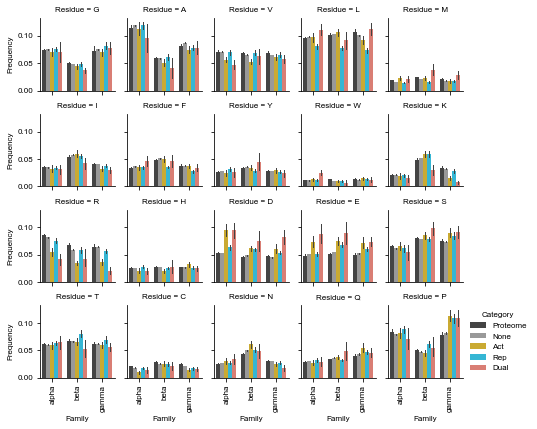

In [7]:
freq_tile = pd.concat([tiledf[['Family', 'Residue', 'Frequency', 'Category']].dropna(), freqdf[['Family', 'Residue', 'Frequency']]])
freq_tile['Category'] = freq_tile['Category'].fillna('Proteome')
freq_tile['Category'] = pd.Categorical(freq_tile['Category'], categories=['Proteome', 'None', 'Act', 'Rep', 'Dual'], ordered=True)

pal = sns.color_palette(['#444444', '#999999', '#E3B919', '#1BC6EE', '#EA7063'])

h = sns.catplot(x='Family', y='Frequency',
                hue='Category', col='Residue',
                data=freq_tile, kind='bar', palette=pal,
                height=1.5, aspect=1, col_wrap=5, errwidth=1, legend=False)
for ax in h.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Category')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHV-hit-categories_amino-acid_frequencies_by_family_with-BG.png', dpi=1200)
freq_tile.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV-hit-categories_amino-acid_frequencies_by_family_with-BG_table.csv', index=False)


C:\Users\cludw\anaconda3\envs\cytoflow\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


   Residue Category  Ratiomean  Ratiostd      Mean     Upper     Lower
1        G     None   1.034491  0.809595  0.048922  0.833985  2.201590
2        G      Act   0.995719  0.580891 -0.006190  0.663015  1.263225
3        G      Rep   1.097898  0.704171  0.134744  0.714910  1.479477
4        G     Dual   1.119856  0.611350  0.163313  0.628464  1.138977
6        A     None   1.072742  0.697206  0.101303  0.722404  1.514279
..     ...      ...        ...       ...       ...       ...       ...
94       Q     Dual   1.274859  0.887448  0.350338  0.762233  1.718399
96       P     None   1.000659  0.797845  0.000950  0.845847  2.302718
97       P      Act   1.217525  0.841513  0.283952  0.758019  1.695102
98       P      Rep   1.279850  0.851140  0.355975  0.735549  1.577901
99       P     Dual   1.377039  0.803551  0.461570  0.663149  1.263734

[80 rows x 7 columns]


<ipython-input-8-b0f64907a1b7>:55: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


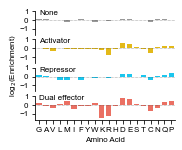

In [8]:
proteome = freq_tile[freq_tile['Category']=='Proteome']
proteome = proteome.groupby(by=['Residue']).agg({'Frequency':['mean', 'std']}).reset_index()
proteome.columns = proteome.columns.get_level_values(0) + proteome.columns.get_level_values(1)
proteome = proteome.rename(columns={'Frequencymean':'Proteome_mean', 'Frequencystd':'Proteome_std'})

FTA = freq_tile.copy()
FTA = pd.merge(FTA, proteome, how='inner', on='Residue')
FTA = FTA.dropna()
FTA['Ratio'] = FTA['Frequency']/FTA['Proteome_mean']
FTAg = FTA.groupby(by=['Residue', 'Category']).agg({'Ratio':['mean', 'std']}).reset_index()
FTAg.columns = FTAg.columns.get_level_values(0) +  FTAg.columns.get_level_values(1)
FTAg = FTAg[FTAg['Category']!='Proteome']
FTAg['Category'] = pd.Categorical(FTAg['Category'], categories=['None', 'Act', 'Rep', 'Dual'], ordered=True)

FTAg['Mean'] = np.log2(FTAg['Ratiomean'])
FTAg['Upper'] = np.log2(FTAg['Ratiomean'] + FTAg['Ratiostd'])
FTAg['Upper'] = FTAg['Upper'] - FTAg['Mean']
FTAg['Lower'] = np.log2(FTAg['Ratiomean'] - FTAg['Ratiostd'])
FTAg['Lower'] = FTAg['Mean'] - FTAg['Lower']

colorDict = {'None':'#999999', 'Act':'#E3B919', 'Rep':'#1BC6EE', 'Dual':'#EA7063'}
labelDict = {'None':'None', 'Act':'Activator', 'Rep':'Repressor', 'Dual':'Dual effector'}
    
def plot_bars(df, subplot, cat):
    df = df[df['Category']==cat]
    for i, r, m, u, l in zip(list(range(len(df))), list(df['Residue']), list(df['Mean']), list(df['Upper']), list(df['Lower'])):
        ax[subplot].bar(x=i, height=m, color=colorDict[cat])
    if subplot == 3:
        ax[subplot].set_xticks(ticks=list(range(len(df))))
        ax[subplot].set_xticklabels(labels=list(df['Residue']))
        ax[subplot].set_xlabel('Amino Acid')
        sns.despine(ax=ax[3])
    else:
        ax[subplot].set_xticks(ticks=[])
        ax[subplot].set_xticklabels(labels=[])
        sns.despine(bottom=True, ax=ax[subplot])
    ax[subplot].axhline(y=0, ls=':', lw=0.5, color='#444444')
    ax[subplot].set_ylim(-1.7, 1)
    ax[subplot].set_xlim(-0.5, 19.5)
    ax[subplot].annotate(text=labelDict[cat], xy=(0, 0.8), ha='left', va='center')
    

FTAg_tiles = FTAg.copy()
print(FTAg)

fig, ax = plt.subplots(4, 1, figsize=(2.5,2))
plot_bars(FTAg, 0, 'None')
plot_bars(FTAg, 1, 'Act')
plot_bars(FTAg, 2, 'Rep')
plot_bars(FTAg, 3, 'Dual')
plt.ylabel('\t\tlog$_2$(Enrichment)\t\t', ha='left')
ax[3].yaxis.set_label_coords(-0.12, -0.5)

plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHV_amino-acid-frequencies_tiles.png', dpi=1200, bbox_inches='tight')

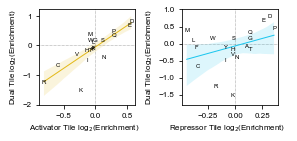

In [56]:
FTAg_tiles_pivot = FTAg_tiles.pivot(index='Residue', columns='Category').reset_index()
# reslist = list(FTAg_tiles_pivot['Residue'])
# actlist = list(FTAg_tiles_pivot['Ratiomean']['Act'])
# replist = list(FTAg_tiles_pivot['Ratiomean']['Rep'])
# duallist = list(FTAg_tiles_pivot['Ratiomean']['Dual'])

# listDict = {'Act':actlist, 'Rep':replist, 'Dual':duallist}
catlist = ['Act', 'Rep']

fig, ax = plt.subplots(1, 2, figsize=(4, 2))
for a, cat in zip(ax.flatten(), catlist):
    sns.regplot(data=FTAg_tiles_pivot, x=FTAg_tiles_pivot['Mean'][cat], y=FTAg_tiles_pivot['Mean']['Dual'],
                scatter_kws={'s':0}, line_kws={'linewidth':1}, ax=a, color=colorDict[cat])#  '#EA7063')
    xlist = list(FTAg_tiles_pivot['Mean'][cat])
    ylist = list(FTAg_tiles_pivot['Mean']['Dual'])
    reslist = list(FTAg_tiles_pivot['Residue'])
    for x, y, res in zip(xlist, ylist, reslist):
        a.annotate(text=res, xy=(x, y), color='k', fontsize=6, ha='center', va='center')
    if cat == 'Act':
        a.set_xlabel('Activator Tile log$_2$(Enrichment)   ')
    elif cat == 'Rep':
        a.set_xlabel('Repressor Tile log$_2$(Enrichment)   ')
    a.set_ylabel('Dual Tile log$_2$(Enrichment)')
    a.set_xlim(a.get_xlim()[0]*1.1, a.get_xlim()[1]*1.1)
    a.set_ylim(a.get_ylim()[0]*1.1, a.get_ylim()[1]*1.1)
    a.axvline(x=0, ls=':', lw=0.5, color='#444444', zorder=0)
    a.axhline(y=0, ls=':', lw=0.5, color='#444444', zorder=0)
plt.tight_layout()  
plt.savefig('../Individual Figure Panels/Figure S5/Correlation_act-dual_vs_rep-dual_tile_enrichments.png', dpi=1200)

<!-- The following plots the distributions of amino acid frequencies for each effector category to see if they are normally distributed (informs which statistical test to use). Not all are normally distributed. Need to specify which family to plot in the 'fam' variable. -->

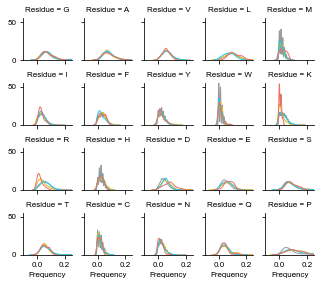

In [9]:
fam = 'gamma'
pal = sns.color_palette(['#999999', '#E3B919', '#1BC6EE', '#EA7063'])
g = sns.FacetGrid(data=tiledf[(tiledf['Family']==fam)], hue='Category', col='Residue', col_wrap=5, aspect=0.9, height=1, palette=pal)
g.map(sns.kdeplot, 'Frequency', common_norm=False, lw=1)
for ax in g.axes.flatten():
    ax.set_ylim(0,55)
    ax.set_xlim(-0.1, 0.25)
# plt.savefig('Figure_4/HHV-hit-categories_amino-acid_frequencies_kde_%sHHV.png' % fam, dpi=300)

We want to compare the means of each effector category's amino acid frequencies with the respective viral family proteome frequency. The populations to be compared are not all normally distributed and are different sizes, so we should use the non-parametric t-test equivalent, which is Welch's t-test. The following computes the Welch's t-test statistic and p-value for each pair and corrects for multiple hypothesis testing (FDR and Bonferroni's). The results are written to a CSV.

In [10]:
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests

tiledf3 = tiledf.copy().dropna()
tiledf3 = tiledf3[['Family', 'Virus', 'Category', 'Residue', 'Frequency']]
freqdf3 = freqdf.copy()
freqdf3 = freqdf3[['Family', 'Virus', 'Residue', 'Frequency']]
freqdf3

fam = []
cat = []
res = []
wtt = []
pval = []

for f in ['alpha', 'beta', 'gamma']:
    for c in ['None', 'Act', 'Rep', 'Dual']:
        for r in list(set(list(tiledf3['Residue']))):
            tile_freqs = list(tiledf3[(tiledf3['Family']==f) & (tiledf3['Category']==c) & (tiledf3['Residue']==r)]['Frequency'])
            bg_freqs = list(freqdf3[(freqdf3['Family']==f) & (freqdf3['Residue']==r)]['Frequency'])
            w_stat, w_p = stats.ttest_ind(tile_freqs, bg_freqs)
            fam.append(f)
            cat.append(c)
            res.append(r)
            wtt.append(w_stat)
            pval.append(w_p)

stat_df = pd.DataFrame({'Family':fam, 'Category':cat, 'Residue':res, 'Welch\'s T':wtt, 'p-value':pval})
pvals = list(stat_df['p-value'])
is_reject, corrected_pvals, _, _ = multipletests(pvals, alpha=0.1, method='fdr_bh')
stat_df['FDR'] = corrected_pvals
stat_df['Bonf'] = stat_df['p-value']*len(stat_df)

stat_df['FDR Sig'] = np.where(stat_df['FDR']<0.1, 1, 0)
stat_df['Bonf Sig'] = np.where(stat_df['Bonf']<0.1, 1, 0)
stat_df = stat_df.sort_values(by=['Residue', 'Family', 'Category', 'FDR'], ascending=True)

stat_df.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV-hit-categories_amino-acid_frequencies_WelchsT-FDR.csv', index=False)
print('Complete')

Complete


The next codeblock produces a volcano plot of the Welch's T statistics by their -log10 p-values for all comparisons. The code block after that does the same but facets by effector category (rows) and residue type (columns).

### Prepare sequences for JPred4 secondary structure prediction and summarize info

In [44]:
dualdf = df[df['Activation']>=cutoffA]
dualdf['Tile ID'] = dualdf['Oligo ID'].str.split('_').str[1:].str.join('_')
dualdf = dualdf.drop_duplicates(subset='Tile ID')
tileIDs = list(dualdf['Tile ID'])
seqList = list(dualdf['Tile Sequence'])

savefile = '../Supplemental Tables - CSV/HHV-perturbation/HHV_all-activator-dual_sequences.fasta'
with open(savefile, 'w') as fasta:
    for ID, seq in zip(tileIDs, seqList):
        fasta.write('>'+ID+'\n')
        fasta.write(seq+'\n')

print('Complete')

Complete


<ipython-input-44-1553d11fc221>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dualdf['Tile ID'] = dualdf['Oligo ID'].str.split('_').str[1:].str.join('_')


In [89]:
import tarfile
jpred4_1 = tarfile.open('../jpred4_results_all/jp_batch_1653791258_actdual_set1_ALL_JOBS_ARCHIVE.tar.gz')
jpred4_1.extractall('../jpred4_results_all/jpred4_results_1')
jpred4_1.close()

jpred4_2 = tarfile.open('../jpred4_results_all/jp_batch_1653791339_actdual_set2_ALL_JOBS_ARCHIVE.tar.gz')
jpred4_2.extractall('../jpred4_results_all/jpred4_results_2')
jpred4_2.close()

jpred4_3 = tarfile.open('../jpred4_results_all/jp_batch_1653791442_actdual_set3_ALL_JOBS_ARCHIVE.tar.gz')
jpred4_3.extractall('../jpred4_results_all/jpred4_results_3')
jpred4_3.close()

In [92]:
# import sys
# !{sys.executable} -m pip install html2text
import html2text

def extract_jpred4(results_dir):
    tileList = []
    seqList = []
    structureList = []

    for sub_dir in os.listdir(results_dir):
        sub_dir_path = os.path.join(results_dir, sub_dir)
        for file in os.listdir(sub_dir_path):
            file_path = os.path.join(sub_dir_path, file)
            if '.name' in file:
                tileID = file[:-5]
                tileList.append(tileID)
            if 'simple' in file:
                first = True
                last = False
                with open(file_path, 'r') as simple_html:
                    count = 0
                    for line in simple_html:
                        decoded = html2text.html2text(line).strip()
                        if len(decoded) != 0:
                            if first:
                                seqList.append(decoded)
                                first = False
                            elif (not first) & (not last):
                                structureList.append(decoded)
                                last = True

    structureList = [s.replace('\\', '') for s in structureList]
    jpred4_df = pd.DataFrame({'Tile ID':tileList, 'Protein Sequence':seqList, 'Structure':structureList})
    jpred4_df.to_csv(results_dir + '_summarized.csv', index=False)
    return jpred4_df

j1 = extract_jpred4('../jpred4_results_all/jpred4_results_1')
j2 = extract_jpred4('../jpred4_results_all/jpred4_results_2')
j3 = extract_jpred4('../jpred4_results_all/jpred4_results_3')

jall = pd.concat([j1, j2, j3])
jall.to_csv('../jpred4_results_all/jpre4_results_combined_summarized.csv', index=False)

print('Complete')

Complete


### Compositional Bias: Domain-level Analysis

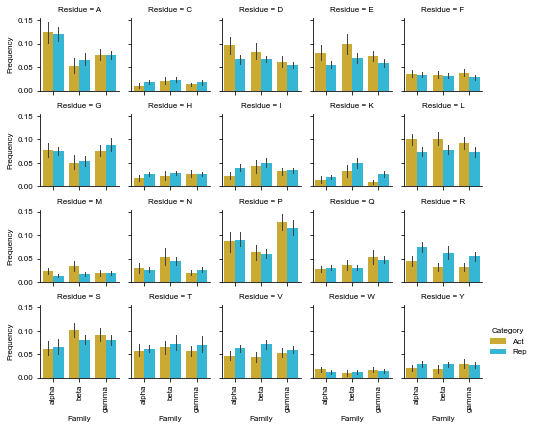

In [45]:
dom = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/HHV_domains.csv')
acts = list(dom[dom['Effect']=='Activation']['Max Sequence'])
reps = list(dom[dom['Effect']=='Repression']['Max Sequence'])
reps = [r for r in reps if r not in acts]
dom = dom[(dom['Effect']=='Activation') | ((dom['Effect']=='Repression') & (dom['Max Sequence'].isin(reps)))]

ids = list(dom['Protein ID'])
seqs = list(dom['Max Sequence'])
cats = list(dom['Effect'])
virs = list(dom['Virus'])

catDict = {'Activation':'Act', 'Repression':'Rep'}

ids2 = []
cats2 = []
virs2 = []
res = []
freq = []

for i, s, c, v in zip(ids, seqs, cats, virs):
    total = 0
    resDict = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 'H':0, 'I':0, 'K':0, 'L':0,
               'M':0, 'N':0, 'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 'W':0, 'Y':0}
    for aa in list(s):
        resDict[aa] += 1
        total += 1        
    for k in resDict:
        ids2.append(i)
        cats2.append(catDict[c])
        virs2.append(v)
        res.append(k)
        freq.append(resDict[k]/total)

domdf = pd.DataFrame({'UniProt ID':ids2, 'Category':cats2, 'Virus':virs2, 'Residue':res, 'Frequency':freq})
domdf['Virus'] = pd.Categorical(domdf['Virus'], categories=['SuHV1', 'HSV1', 'HSV2', 'VZV', 'HCMV', 'HHV6A', 'HHV6B', 'HHV7', 'EBV', 'KSHV'], ordered=True)
domdf['Category'] = pd.Categorical(domdf['Category'], categories=['Act', 'Rep'])
domdf = domdf.sort_values(by=['Residue', 'Virus', 'Category'])
family = {'SuHV1':'alpha', 'HSV1':'alpha', 'HSV2':'alpha', 'VZV':'alpha', 'HCMV':'beta', 'HHV6A':'beta', 'HHV6B':'beta', 'HHV7':'beta', 'EBV':'gamma', 'KSHV':'gamma'}
domdf['Family'] = domdf['Virus'].map(family)

pal = sns.color_palette(['#E3B919', '#1BC6EE'])
g = sns.catplot(x='Virus', y='Frequency',
                hue='Category', col='Residue',
                data=domdf, kind='bar', palette=pal,
                height=1.5, aspect=1.5, col_wrap=5, errwidth=1, legend=False)
for ax in g.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Category')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHV-dom-categories_amino-acid_frequencies_by_virus.png', dpi=1200)
plt.close()

h = sns.catplot(x='Family', y='Frequency',
                hue='Category', col='Residue',
                data=domdf, kind='bar', palette=pal,
                height=1.5, aspect=1, col_wrap=5, errwidth=1, legend=False)
for ax in h.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Category')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHV-dom-categories_amino-acid_frequencies_by_family.png', dpi=1200)

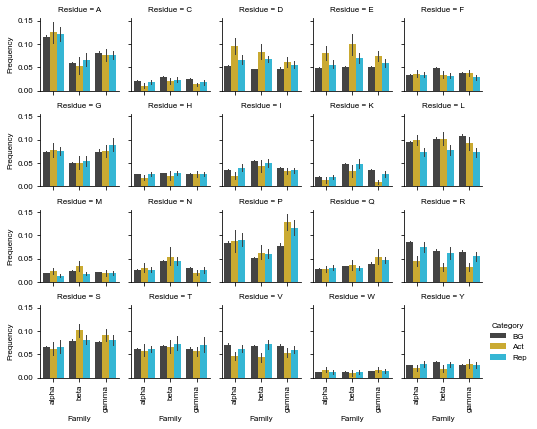

In [46]:
freq_tile = pd.concat([domdf[['Family', 'Residue', 'Frequency', 'Category']].dropna(), freqdf[['Family', 'Residue', 'Frequency']]])
freq_tile['Category'] = freq_tile['Category'].fillna('BG')
freq_tile['Category'] = pd.Categorical(freq_tile['Category'], categories=['BG', 'Act', 'Rep'], ordered=True)

pal = sns.color_palette(['#444444', '#E3B919', '#1BC6EE'])

h = sns.catplot(x='Family', y='Frequency',
                hue='Category', col='Residue',
                data=freq_tile, kind='bar', palette=pal,
                height=1.5, aspect=1, col_wrap=5, errwidth=1, legend=False)
for ax in h.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Category')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHV-dom-categories_amino-acid_frequencies_by_family_with-BG.png', dpi=1200)

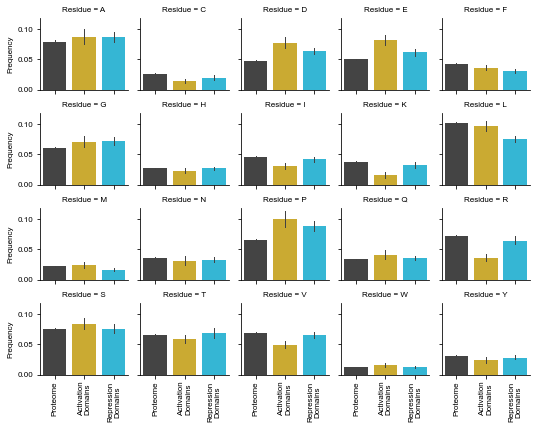

In [47]:
freq_tile = pd.concat([domdf[['Family', 'Residue', 'Frequency', 'Category']].dropna(), freqdf[['Family', 'Residue', 'Frequency']]])
freq_tile['Category'] = freq_tile['Category'].fillna('Proteome')

freq_tile_sum = freq_tile.groupby(by=['Residue', 'Category']).mean().reset_index()
freq_tile_sum.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV-dom-categories_amino-acid_frequencies_aggregate_with-BG_table.csv', index=False)

freq_tile['Category'] = freq_tile['Category'].replace(['Act', 'Rep'], ['Activation\nDomains', 'Repression\nDomains'])
freq_tile['Category'] = pd.Categorical(freq_tile['Category'], categories=['Proteome', 'Activation\nDomains', 'Repression\nDomains'], ordered=True)

pal = sns.color_palette(['#444444', '#E3B919', '#1BC6EE'])

h = sns.catplot(x='Category', y='Frequency',
                col='Residue',
                data=freq_tile, kind='bar', palette=pal,
                height=1.5, aspect=1, col_wrap=5, errwidth=1, legend=False)
for ax in h.axes.flatten():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
    ax.set_xlabel('')
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Category')
plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure S5/HHV-dom-categories_amino-acid_frequencies_aggregate_with-BG.png', dpi=1200)


In [48]:
import scipy.stats as stats
from statsmodels.sandbox.stats.multicomp import multipletests

domdf2 = domdf.copy().dropna()
domdf2 = domdf2[['Family', 'Virus', 'Category', 'Residue', 'Frequency']]
freqdf3 = freqdf.copy()
freqdf3 = freqdf3[['Family', 'Virus', 'Residue', 'Frequency']]

cat = []
res = []
wtt = []
pval = []

for c in ['Act', 'Rep']:
    for r in list(set(list(domdf2['Residue']))):
        tile_freqs = list(domdf2[(domdf2['Category']==c) & (domdf2['Residue']==r)]['Frequency'])
        bg_freqs = list(freqdf3[freqdf3['Residue']==r]['Frequency'])
        w_stat, w_p = stats.ttest_ind(tile_freqs, bg_freqs)
        cat.append(c)
        res.append(r)
        wtt.append(w_stat)
        pval.append(w_p)

stat_df = pd.DataFrame({'Category':cat, 'Residue':res, 'Welch\'s T':wtt, 'p-value':pval})
pvals = list(stat_df['p-value'])
is_reject, corrected_pvals, _, _ = multipletests(pvals, alpha=0.1, method='fdr_bh')
stat_df['FDR'] = corrected_pvals
stat_df['Bonf'] = stat_df['p-value']*len(stat_df)

stat_df['FDR Sig'] = np.where(stat_df['FDR']<0.05, 1, 0)
stat_df['Bonf Sig'] = np.where(stat_df['Bonf']<0.05, 1, 0)

resorder = ['G', 'A', 'V', 'L', 'M', 'I', 'F', 'Y', 'W', 'K', 'R', 'H', 'D', 'E', 'S', 'T', 'C', 'N', 'Q', 'P']
stat_df['Residue'] = pd.Categorical(stat_df['Residue'], categories=resorder, ordered=True)
stat_df = stat_df.sort_values(by=['Residue', 'Category', 'FDR'], ascending=True).reset_index(drop=True)

stat_df.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV-dom-categories_amino-acid_frequencies_aggregate_WelchsT-FDR.csv', index=False)
print('Complete')

Complete


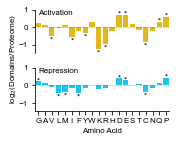

In [50]:
resorder = ['G', 'A', 'V', 'L', 'M', 'I', 'F', 'Y', 'W', 'K', 'R', 'H', 'D', 'E', 'S', 'T', 'C', 'N', 'Q', 'P']

proteome = freq_tile[freq_tile['Category']=='Proteome']
proteome = proteome.groupby(by=['Residue']).agg({'Frequency':['mean', 'std']}).reset_index()
proteome.columns = proteome.columns.get_level_values(0) + proteome.columns.get_level_values(1)
proteome = proteome.rename(columns={'Frequencymean':'Proteome_mean', 'Frequencystd':'Proteome_std'})

FTA = freq_tile[freq_tile['Category']!='Proteome']
FTA = FTA.replace(['Activation\nDomains', 'Repression\nDomains'], ['Act', 'Rep'])
FTA = pd.merge(FTA, proteome, how='inner', on='Residue')
FTA = FTA.dropna()
FTA['Ratio'] = FTA['Frequency']/FTA['Proteome_mean']
FTAg = FTA.groupby(by=['Residue', 'Category']).agg({'Ratio':['mean', 'std']}).reset_index()
FTAg.columns = FTAg.columns.get_level_values(0) +  FTAg.columns.get_level_values(1)
FTAg['Category'] = pd.Categorical(FTAg['Category'], categories=['Act', 'Rep'], ordered=True)

FTAg['Mean'] = np.log2(FTAg['Ratiomean'])
FTAg['Residue'] = pd.Categorical(FTAg['Residue'], categories=resorder, ordered=True)
FTAg = FTAg.dropna().sort_values(by=['Residue', 'Category']).reset_index(drop=True)
FTAg = pd.merge(FTAg, stat_df, on=['Residue', 'Category'], how='inner')

colorDict = {'None':'#999999', 'Act':'#E3B919', 'Rep':'#1BC6EE', 'Dual':'#EA7063'}
labelDict = {'None':'None', 'Act':'Activation', 'Rep':'Repression', 'Dual':'Dual effector'}
    
def plot_bars(df, subplot, cat):
    df = df[df['Category']==cat]
    for i, r, m, sig in zip(list(range(len(df))), list(df['Residue']), list(df['Mean']), list(df['Bonf Sig'])):
        ax[subplot].bar(x=i, height=m, color=colorDict[cat])
        if sig == 1:
            if m < 0:
                ax[subplot].annotate(text='*', xy=(i, m-0.2), ha='center', va='center')
            else:
                ax[subplot].annotate(text='*', xy=(i, m+0.05), ha='center', va='center')
#         ax[subplot].errorbar(x=i, y=m, yerr=[[u], [l]], lw=0.5, color='k')
    if subplot == 1:
        ax[subplot].set_xticks(ticks=list(range(len(df))))
        ax[subplot].set_xticklabels(labels=list(df['Residue']))
        ax[subplot].set_xlabel('Amino Acid')
        sns.despine(ax=ax[1])
    else:
        ax[subplot].set_xticks(ticks=[])
        ax[subplot].set_xticklabels(labels=[])
        sns.despine(bottom=True, ax=ax[subplot])
    ax[subplot].axhline(y=0, ls=':', lw=0.5, color='#444444')
    ax[subplot].set_ylim(-1.45, 1)
    ax[subplot].set_xlim(-0.5, 19.5)
    ax[subplot].annotate(text=labelDict[cat], xy=(0, 0.8), ha='left', va='center')
    
FTAg_doms = FTAg.copy()
fig, ax = plt.subplots(2, 1, figsize=(2.5,2))
plot_bars(FTAg, 0, 'Act')
plot_bars(FTAg, 1, 'Rep')
plt.ylabel('log$_2$(Domains/Proteome)', ha='left')
ax[1].yaxis.set_label_coords(-0.12, 0.15)

plt.tight_layout()
plt.savefig('../Individual Figure Panels/Figure 5/HHV_amino-acid-frequencies_domains.png', dpi=1200, bbox_inches='tight')

#### Using the tile-level and domain-level analyses (FTAg_tiles and FTAg_doms) - not featured in a figure panel

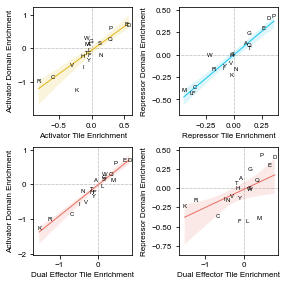

In [254]:
tilesDF = FTAg_tiles[FTAg_tiles['Category'].isin(['Act', 'Rep', 'Dual'])]
tilesDF = tilesDF[['Residue', 'Category', 'Mean']].rename(columns={'Mean':'Tile'})
domsDF = FTAg_doms.replace(['Activation\nDomains', 'Repression\nDomains'], ['Act', 'Rep'])
domsDF = domsDF[['Residue', 'Category', 'Mean']].rename(columns={'Mean':'Domain'})
aggDF = pd.merge(domsDF, tilesDF, on=['Residue', 'Category'], how='left')

dualADF = pd.merge(domsDF[domsDF['Category']=='Act'].replace(['Act'], ['Dual-Act']), tilesDF[tilesDF['Category']=='Dual'].replace(['Dual'], ['Dual-Act']), on=['Residue', 'Category'], how='left')
dualRDF = pd.merge(domsDF[domsDF['Category']=='Rep'].replace(['Rep'], ['Dual-Rep']), tilesDF[tilesDF['Category']=='Dual'].replace(['Dual'], ['Dual-Rep']), on=['Residue', 'Category'], how='left')

aggDF = pd.concat([aggDF, dualADF, dualRDF])
aggDF = aggDF.sort_values(by=['Residue', 'Category']).reset_index(drop=True)
aggDF

# aggDF
fig, ax = plt.subplots(2, 2, figsize=(4, 4))

catlist = ['Act', 'Rep', 'Dual-Act', 'Dual-Rep']
colorlist = ['#E3B919', '#1BC6EE', '#EA7063', '#EA7063']
labellist = [('Activator', 'Activator'), ('Repressor', 'Repressor'), ('Activator', 'Dual Effector'), ('Repressor', 'Dual Effector')]

for a, cat, color, label in zip(ax.flatten(), catlist, colorlist, labellist):
    tempdf = aggDF[aggDF['Category']==cat]
    res = list(tempdf['Residue'])
    xpos = list(tempdf['Tile'])
    ypos = list(tempdf['Domain'])
    sns.regplot(data=tempdf, x='Tile', y='Domain', ax=a,
                color=color, scatter_kws={'s':0}, line_kws={'linewidth':1})
    for r, x, y in zip(res, xpos, ypos):
        a.annotate(text=r, xy=(x,y), color='k', fontsize=6, ha='center', va='center')
    a.set_ylabel(label[0] + ' Domain Enrichment')
    a.set_xlabel(label[1] + ' Tile Enrichment')
    a.set_xlim(a.get_xlim()[0]*1.1, a.get_xlim()[1]*1.1)
    a.set_ylim(a.get_ylim()[0]*1.1, a.get_ylim()[1]*1.1)
    a.axvline(x=0, ls=':', lw=0.5, color='#444444', zorder=-1)
    a.axhline(y=0, ls=':', lw=0.5, color='#444444', zorder=-1)

plt.tight_layout()
# plt.savefig('Figure_4/HHV_amino-acid-frequencies_tiles-vs-domains.png', dpi=1200)

### EBNA2 Type 2 Activation Domain Perturbation Tiling Plot

In [58]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from statistics import geometric_mean

font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

# filter out library members with too few reads, add meta data about perturbation type, and calculate hits threshold
# screen_type should be 'Act' or 'Rep'
def process_screen(df, screen_type, sigma, counts_filter):
    df['countsSUM_R1'] = df['countsON_R1'] + df['countsOFF_R1']
    df['countsSUM_R2'] = df['countsON_R2'] + df['countsOFF_R2']
    df = df[(df['countsSUM_R1']>=counts_filter) & (df['countsSUM_R2']>=counts_filter)]
    
    df = df.rename(columns={'label':'Oligo ID'})
    df['Type'] = np.where(df['Oligo ID'].str.contains('random'), 'random', 'substitution')
    df['Type'] = np.where(df['Oligo ID'].str.contains('del5'), 'deletion', df['Type'])
    df['Type'] = np.where(df['Oligo ID'].str.contains('fiducial'), 'fiducial', df['Type'])
    df['Type'] = np.where(df['Oligo ID'].str.contains('_WT'), 'WT', df['Type'])
    
    if screen_type == 'Act':
        df['R1'] = -df['R1']
        df['R2'] = -df['R2']
        df['Avg'] = -df['Avg']
        
    rand = list(df[df['Type']=='random']['Avg'])
    thresh = np.mean(rand) + sigma*np.std(rand)
    df['Hit'] = np.where(df['Avg']>=thresh, 1, 0)
    
    return df, thresh

# add additional information, including fiducial details, WT tile effect, and other meta data
# IMPORTANT: all mutations are off by +1, so this code corrects for that
def add_info(df, fiducials, maxTiles, prot_seqs):
    # merge in fiducial information and protein sequences
    df['Full Tile ID'] = df['Oligo ID'].str.split('_').str[1:].str.join('_')
    df = pd.merge(df, fiducials[['Full Tile ID', 'Gene', 'Effect']], on='Full Tile ID', how='left')
    df = pd.merge(df, prot_seqs, on='Full Tile ID', how='left')
    df['Effect'] = np.where(df['Effect'].isnull(), '-', df['Effect'])
    df['Tile ID'] = np.where(~df['Full Tile ID'].str.contains('fiducial|random'), df['Full Tile ID'].str.split('_').str[:-1].str.join('_'), '-')
    df['Mutation'] = np.where(~df['Full Tile ID'].str.contains('fiducial|random'), df['Full Tile ID'].str.split('_').str[-1], '-')
    
    # isolate mutations and position information
    df['Original'] = np.where(df['Type'].isin(['substitution', 'deletion']), df['Mutation'].str[0], '-')
    df['Position'] = np.where(df['Type']=='substitution', df['Mutation'].str[1:-1], '-')
    df['Perturbation'] = np.where(df['Type']=='substitution', df['Mutation'].str[-1], '-')
    df['Position'] = np.where(df['Type']=='deletion', df['Mutation'].str[1:-4], df['Position'])
    df['Perturbation'] = np.where(df['Type']=='deletion', 'del5', df['Perturbation'])
    df['Position'] = [int(p) - 1 if p!='-' else '-' for p in list(df['Position'])]
    
    # correct mutation position in the 'Mutation', 'Full Tile ID', and 'Oligo ID' fields
    df['Mutation'] = np.where(df['Type'].isin(['substitution', 'deletion']), df['Original'] + df['Position'].astype(str) + df['Perturbation'], df['Mutation'])
    df['Full Tile ID'] = np.where(df['Type'].isin(['substitution', 'deletion']), df['Tile ID'] + '_' + df['Mutation'], df['Full Tile ID'])
    df['Oligo ID'] = np.where(df['Type'].isin(['substitution', 'deletion']), 'HHV-DMS_' + df['Full Tile ID'], df['Oligo ID'])
    
    df = pd.merge(df, maxTiles, on='Tile ID', how='outer')
    df['Effect'] = np.where(df['Effect_y'].isnull(), df['Effect_x'], df['Effect_y'])
    df = df.drop(columns=['Effect_x', 'Effect_y', 'Gene'])
    
    return df

# read in necessary files as dataframes: screen scores, fiducials, and details on original WT max tiles
Act = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ActivD2_combo.csv', sep=',')
Rep = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ReprD5_combo.csv', sep=',')
orig_cutoffA = 1.0846347878236864
orig_cutoffR = 0.6987727639587653

fiducials = pd.read_csv('../Supplemental Tables - CSV/fiducial_controls.csv', sep=',').drop(columns='Unnamed: 0')
fiducials['Number'] = fiducials.index + 1
fiducials['Full Tile ID'] = 'fiducial_' + fiducials['Number'].astype(str).str.zfill(3)
fiducials['Effect'] = np.where(fiducials['Description'].str.contains('Repr'), 'repressor', 'activator')
fiducials['Effect'] = np.where(fiducials['label'].str.contains('random'), '-', fiducials['Effect'])

maxTiles = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV-perturb_max-tiles.csv')
maxTiles['Effect'] = np.where((maxTiles['Activation']>=orig_cutoffA), 'activator', '-')
maxTiles['Effect'] = np.where((maxTiles['Repression']>=orig_cutoffR), 'repressor', maxTiles['Effect'])
maxTiles['Effect'] = np.where((maxTiles['Activation']>=orig_cutoffA) & (maxTiles['Repression']>=orig_cutoffR), 'dual', maxTiles['Effect'])
maxTiles = maxTiles[['Tile ID', 'Tile Start', 'Tile End', 'Effect', 'Protein', 'Virus Abbreviation']]

prot_seqs = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV_Hits_DMS_codon-opt-proteins_oligos.csv')
prot_seqs = prot_seqs[['Name', 'Protein Sequence']].rename(columns={'Name':'Full Tile ID'})

# process files
Act, threshA = process_screen(Act, 'Act', 2, 50)
Act = add_info(Act, fiducials, maxTiles, prot_seqs)
Act.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ActivD2_combo_expanded.csv', index=False)
E1act = list(Act[(Act['Type']=='WT') & (Act['Oligo ID'].str.contains('P12978'))]['Avg'])[0]
print(E1act)

Rep, threshR = process_screen(Rep, 'Rep', 2, 50)
Rep = add_info(Rep, fiducials, maxTiles, prot_seqs)
Rep.to_csv('../Supplemental Tables - CSV/HHV-perturbation/HHVpert_ReprD5_combo_expanded.csv', index=False)

print('Activation threshold: %s' % str(threshA))
print('Repression threshold: %s' % str(threshR))
print('Complete')

2.955520504972891
Activation threshold: -1.393846406032031
Repression threshold: -1.071410423724703
Complete


In [59]:
### Standard deviation in WT scores
WT_A = 0.21506548936633008
WT_R = 0.17315610959701574
threshA = -1.393846406032031
threshR = -1.071410423724703

In [60]:
import os
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

jpred4 = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/jpred4_results_summarized.csv').drop(columns='Protein Sequence')
dropoutDict = {'P12978_010':'PPPPPPPPPPQRRDAWTQEPSPLDRDPLGYDVGHGPLASAMRMLWMANYIVRQSRGDRGLILPQGPQTAPQARLVQPHVP',
               'P52351_041':'TKKKKRYREDDDRELTKDKNDIKELVDAIGMLRHEISALKYIRSQSPQRQHCTAVDTMPTIEEKNVASPKPSVVNASLTP'}
coords = {'P12978_010':[91, 170], 'P52351_041':[401, 480]}

# generate tiling plots containing all info and sequence
def tiling_plot(df, effect_type, thresh, structure):
    # set variables based on effect type
    if effect_type == 'activator':
        color = '#D7AC00'
        ylabel = 'Activation\nlog$_2$(ON:OFF)'
        savedir = '../Individual Figure Panels/Figure 5' # 'Activator_Perturbations'
        sigma2 = 2*WT_A
        
    elif effect_type == 'repressor':
        color = '#23BEDB'
        ylabel = 'Repression\nlog$_2$(OFF:ON)'
        savedir = '../Individual Figure Panels/Figure 5' # 'Repressor_Perturbations'
        sigma2 = 2*WT_R
    
    # check if output directory exists - if not, make directory
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    
    # subset dataframe to focus on those with correct activity, determine y-limits, and get list of tile identifiers
    df = pd.merge(df, structure, on='Tile ID', how='left')
    df = df[df['Effect'].isin([effect_type, 'dual'])]
    df = df[df['Tile ID'].str.contains('Q69022|P52534')]
    ymax = max(list(df['R1']) + list(df['R2']))*1.2
    ymin = min(list(df['R1']) + list(df['R2']))*1.2
    tileList = list(set(list(df[df['Tile ID']!='-']['Tile ID'])))
    
    # for each tile, create plot with effect of all perturbations
    for tile in tileList:
        tempdf = df[df['Tile ID']==tile]
        # if WT sequence not in the subsetted dataframe, then don't make plot
        if 'WT' not in list(tempdf['Type']):
            virus = list(tempdf['Virus Abbreviation'])[0]
            protein = list(tempdf['Protein'])[0]
            print('No WT measurement for %s %s (%s)' % (virus, protein, tile))
            WT_seq = dropoutDict[tile]
            WT_struct = ''.join(['-']*80)
            print(WT_struct)
            start = coords[tile][0]
            end = coords[tile][1] + 1

        else:
            # extract information about WT sequence: virus, protein, scores for each replicate, sequence, and coordinates
            virus = list(tempdf[tempdf['Type']=='WT']['Virus Abbreviation'])[0]
            protein = list(tempdf[tempdf['Type']=='WT']['Protein'])[0]
            WT_avg = list(tempdf[tempdf['Type']=='WT']['Avg'])[0]
            WT_vals = [WT_avg + sigma2, WT_avg - sigma2]
            WT_seq = list(tempdf[tempdf['Type']=='WT']['Protein Sequence'])[0]
            WT_struct = list(tempdf[tempdf['Type']=='WT']['Structure'])[0]
            start = int(list(tempdf[tempdf['Type']=='WT']['Tile Start'])[0])
            end = int(list(tempdf[tempdf['Type']=='WT']['Tile End'])[0]) + 1
        xticks = list(range(start, end, 1))
        xticks_mod = [x - 0.5 for x in xticks]
        xrange = list(range(start, end+1, 5))
        
        # create dataframes for specific subplots
        struct_dict = {'-':'#FFFFFF', 'E':'#555555', 'H':'#AAAAAA'}
        WT_struct = [struct_dict[s] for s in WT_struct if s in struct_dict]
        struct_df = pd.DataFrame(index=xticks, data={'JPred4':list(WT_struct)}).T
        
        deletion = tempdf[tempdf['Type']=='deletion']
        deletion = deletion.sort_values(by='Position')
        delx = [p + 2 for p in list(deletion['Position'])]
        dely = list(deletion['Avg'])
        delyerr = list(deletion['Standard Error'])
        
        subs = tempdf[tempdf['Type']=='substitution']
        subs['mut2plot'] = subs['Original'] + ':' + subs['Perturbation']
        subs = subs.sort_values(by='Position')
        subx = list(subs['Position'])
        suby = list(subs['Avg'])
        subyerr = list(subs['Standard Error'])
        subaa = list(subs['Perturbation'])
        sub_nonhit = list(subs[subs['Hit']==0]['Position'])
        
        # initialize plots
        fig, ax = plt.subplots(2, 1, figsize=(3.5,1.5), gridspec_kw={'height_ratios':[1, 19]}, sharex=False)
        plt.subplots_adjust(hspace=0.03)
        
        ax[0].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
        ax[0].set_xticks([])
        ax[0].set_ylim(1,2)
        ax[0].set_yticks([])
        ax[0].set_ylabel('', rotation=0, va='center', ha='right')
        sns.despine(left=True, bottom=True, ax=ax[0])
        for s, x in zip(list(WT_struct), xticks_mod):
              ax[0].add_patch(Rectangle((x, 1), 1, 1, edgecolor='white', facecolor='white'))
            
        custom_patch = [Line2D([0], [0], color='#555555', marker='s', lw=0),
                        Line2D([0], [0], color='#AAAAAA', marker='s', lw=0)]
                
        # plot deletion scan data, with WT scores as horizontal span
        ax[1].set_xlim(xrange[0]-0.5, xrange[-1]-0.5)
        ax[1].xaxis.set_major_locator(MultipleLocator(10))
        ax[1].xaxis.set_minor_locator(MultipleLocator(5))
        ax[1].set_ylim(ymin, ymax)
        ax[1].axhline(y=thresh, color='#333333', ls=':', zorder=-5, lw=0.5)
        if 'WT' in list(tempdf['Type']):
            ax[1].axhspan(ymax=WT_vals[0], ymin=WT_vals[1], color=color, alpha=0.25, zorder=-2)
            ax[1].axhline(y=WT_avg, color=color, ls=':', zorder=-1, lw=0.5)
        if protein == 'EBNA2':
            ax[1].axhline(y=E1act, color='#9d7d27', ls='-.', zorder=-1, lw=0.5)
            ax[1].annotate(text='Type 1 WT score', xy=(351, 3.3), ha='left', va='center', color='#9d7d27', fontsize=6)
        
        for x in xrange:
            ax[1].axvline(x=x-0.5, color='#DDDDDD', ls=':', lw=0.5)
        
        plotdf_del = pd.DataFrame({'X':delx, 'Y':dely})
        sns.scatterplot(data=plotdf_del, x='X', y='Y', color=color, ax=ax[1], linewidth=0, s=0)
        for x, y, ye in zip(delx, dely, delyerr):
            ax[1].errorbar(x, y, xerr=2.5, yerr=ye, color=color, zorder=100, lw=1.2)
        
        # plot substitution data
        for x, y, aa in zip(subx, suby, subaa):
            ax[1].plot(x, y, marker='o', color=color, markersize=1.5)
            if (x == 409) & (aa=='D'):
                ax[1].plot(x, y, marker='*', markersize=5, color=color, mew=0.5)
        
        if protein == 'EBNA2':
            title = virus + ' ' + protein + ' Type 2 (' + tile.split('_')[0] + ')' #'\n\n'
        else:
            title = virus + ' ' + protein + ' (' + tile.split('_')[0] + ')'
        ax[1].set_xlabel('Residue Position along %s' % title) #Protein')
        ax[1].set_ylabel(ylabel)
        
        savename = '_'.join([virus, protein, tile, effect_type, 'perturb.png'])
        plt.tight_layout()
        plt.subplots_adjust(hspace=0.1)
        plt.savefig(os.path.join(savedir, savename), dpi=1200, bbox_inches='tight')
        plt.close()
        
tiling_plot(Act, 'activator', threshA, jpred4)
tiling_plot(Rep, 'repressor', threshR, jpred4)
print('Complete')

<ipython-input-60-52c7ba508bd2>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs['mut2plot'] = subs['Original'] + ':' + subs['Perturbation']
<ipython-input-60-52c7ba508bd2>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subs['mut2plot'] = subs['Original'] + ':' + subs['Perturbation']


Complete


### Get fasta with every HHV protein

In [61]:
origProt = pd.read_csv('../Supplemental Tables - CSV/HHV-tiling/uniref_reviewed_HHV+SuHV.csv').rename(columns={'Cluster ID':'UniProt ID'})
keyHHV = pd.read_csv('../Supplemental Tables - CSV/uID_protein_virus_mapping_HHV_expanded.csv').drop_duplicates(subset=['UniProt ID', 'Original'])
origProt = pd.merge(origProt, keyHHV, on=['UniProt ID'], how='inner')
origProt = origProt[['UniProt ID', 'Representative Sequence', 'Virus', 'Protein', 'Gene']]
origProt['Protein'] = np.where(origProt['UniProt ID']=='P33485', 'ORF3', origProt['Protein'])

uniprot = list(origProt['UniProt ID'])
sequence = list(origProt['Representative Sequence'])
virus = list(origProt['Virus'])
protein = list(origProt['Protein'])
gene = list(origProt['Gene'])

with open('../Supplemental Tables - CSV/HHV-tiling/HHV_all_proteins.fasta', 'w') as outFile:
    for uID, seq, vir, prot, gen in zip(uniprot, sequence, virus, protein, gene):
        header = '>%s|-|%s;%s;%s' % (uID, vir, prot, gen)
        outFile.write(header + '\n' + seq + '\n')

outFile.close()
print('Fasta written')

Fasta written


### Stacked barplots with global analysis of substitution effects

#### Barplots featured in Fig. 5H & 5I

In [63]:
from matplotlib.lines import Line2D

font = {'family' : 'Arial',
        'size'   : 8}

matplotlib.rc('font', **font)

dropoutDict = {'P12978_010':'PPPPPPPPPPQRRDAWTQEPSPLDRDPLGYDVGHGPLASAMRMLWMANYIVRQSRGDRGLILPQGPQTAPQARLVQPHVP',
               'P52351_041':'TKKKKRYREDDDRELTKDKNDIKELVDAIGMLRHEISALKYIRSQSPQRQHCTAVDTMPTIEEKNVASPKPSVVNASLTP'}
dropoutcoords = {'P12978_010':[91, 170], 'P52351_041':[401, 480]}
estWT = {'P12978_010':146, 'P52351_041':446}

# generate stacked bar plots showing what fraction of substitutions enhance, do nothing, reduce, break tile activity
def effect_stacked_bar(df, effect_type, thresh):
    # set variables based on effect type
    if effect_type == 'activator':
        colors = sns.color_palette(['#D7AC00', '#E7CD66', '#CCCCCC', '#999999'])
        title = 'Effect of Substitutions on Activation'
        sigma2 = 2*WT_A
        df = df[df['Effect'].isin([effect_type, 'dual'])]
        
    elif effect_type == 'repressor':
        colors = sns.color_palette(['#23BEDB', '#7BD8E9', '#CCCCCC', '#999999'])
        title = 'Effect of Substitutions on Repression'
        sigma2 = 2*WT_R
        df = df[df['Effect'].isin([effect_type])]
    
    # subset dataframe to focus on those with correct activity, determine y-limits, and get list of tile identifiers
    tileList = list(set(list(df[df['Tile ID']!='-']['Tile ID'])))
    
    sub_change = []
    sub_direction = []
    
    # for each tile, create plot with effect of all perturbations
    for tile in tileList:
        tempdf = df[df['Tile ID']==tile]
        # if WT sequence not in the subsetted dataframe, then don't make plot
        if 'WT' not in list(tempdf['Type']):
            virus = list(tempdf['Virus Abbreviation'])[0]
            protein = list(tempdf['Protein'])[0]
            WT_avg = np.mean(list(tempdf[tempdf['Position']>estWT[tile]]['Avg']))
            WT_vals = [WT_avg + sigma2, WT_avg - sigma2]
            WT_seq = dropoutDict[tile]
            print('No WT measurement for %s %s (%s)' % (virus, protein, tile))
        
        else:
            # extract information about WT sequence: virus, protein, scores for each replicate, sequence, and coordinates
            virus = list(tempdf[tempdf['Type']=='WT']['Virus Abbreviation'])[0]
            protein = list(tempdf[tempdf['Type']=='WT']['Protein'])[0]
            WT_avg = list(tempdf[tempdf['Type']=='WT']['Avg'])[0]
            WT_vals = [WT_avg + sigma2, WT_avg - sigma2]
            WT_seq = list(tempdf[tempdf['Type']=='WT']['Protein Sequence'])[0]
            start = int(list(tempdf[tempdf['Type']=='WT']['Tile Start'])[0])
            end = int(list(tempdf[tempdf['Type']=='WT']['Tile End'])[0]) + 1

        # substitutions
        subs = tempdf[tempdf['Type']=='substitution']
        sub_original = list(subs['Original'])
        sub_new = list(subs['Perturbation'])
        sub_score = list(subs['Avg'])
        
        for o, n, s in zip(sub_original, sub_new, sub_score):
            key = o + ':' + n
            sub_change.append(key)
            if s > WT_vals[0]:
                sub_direction.append('Enhancing')
            elif (s <= WT_vals[0]) & (s >= WT_vals[1]):
                sub_direction.append('No Effect')
            elif (s < WT_vals[1]) & (s >= thresh):
                sub_direction.append('Reducing')
            else:
                sub_direction.append('Breaking')

    new_df = pd.DataFrame({'Substitution':sub_change, 'Effect':sub_direction})
    
    eff_cats = ['Enhancing', 'No Effect', 'Reducing', 'Breaking']
    new_df['Effect'] = pd.Categorical(new_df['Effect'], categories=eff_cats)
    mut_cats = ['W:A', 'F:A', 'Y:A', 'D:A', 'D:N', 'E:A', 'E:Q', 'K:A', 'K:Q', 'K:R', 'R:A', 'S:D', 'T:D', 'Q:A', 'P:A']
    new_df['Substitution'] = pd.Categorical(new_df['Substitution'], categories=mut_cats)
    
    new_df['Count'] = 1
    new_df = new_df.groupby(by=['Substitution', 'Effect']).sum()
    new_df['Percent'] = new_df.groupby(level=0).transform(lambda x: (x/x.sum()).round(4))
    fig, ax = plt.subplots(1, 1, figsize=(3.1,1.5))
    sns.histplot(data=new_df.sort_values(by=['Substitution', 'Effect']), x='Substitution', hue='Effect', weights='Percent', multiple='stack', ax=ax,
                 palette=colors, edgecolor='#FFFFFF', linewidth=0.5)
    custom_patch = [Line2D([0], [0], color=colors[0], marker='s', lw=0),
                    Line2D([0], [0], color=colors[1], marker='s', lw=0),
                    Line2D([0], [0], color=colors[2], marker='s', lw=0),
                    Line2D([0], [0], color=colors[3], marker='s', lw=0)]
    ax.legend(custom_patch, eff_cats, loc='center left',
              bbox_to_anchor=(1, 0.5), frameon=False, handletextpad=-0.3,
              labelspacing=0.3, borderpad=-0.6, title='Effect vs WT')
    ax.set_ylabel('Fraction of\nSubstitutions')
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_ylim(0,1)
    for l in ax.get_xticklabels():
        l.set_rotation(90)
    ax.set_xlim(-0.5, len(mut_cats)-0.5)
    ax.set_title(title, fontsize=8)
    plt.tight_layout()
    plt.savefig('../Individual Figure Panels/Figure 5/fraction-substitutions-effect_%s.png' % effect_type, dpi=1200)
    plt.close()
    return None
         
effect_stacked_bar(Act, 'activator', threshA)
effect_stacked_bar(Rep, 'repressor', threshR)

print('Complete')

No WT measurement for HHV7 SCAF (P52351_041)
No WT measurement for EBV EBNA2 (P12978_010)
Complete


### Compute frequency of residues in essential deleted regions

In [64]:
# frequencies across the entire domain first
dropoutDict = {'P12978_010':'PPPPPPPPPPQRRDAWTQEPSPLDRDPLGYDVGHGPLASAMRMLWMANYIVRQSRGDRGLILPQGPQTAPQARLVQPHVP',
               'P52351_041':'TKKKKRYREDDDRELTKDKNDIKELVDAIGMLRHEISALKYIRSQSPQRQHCTAVDTMPTIEEKNVASPKPSVVNASLTP'}
dropoutcoords = {'P12978_010':[91, 170], 'P52351_041':[401, 480]}
estWT = {'P12978_010':146, 'P52351_041':446}

def domain_seqs(df, effect_type):
    # set variables based on effect type
    df = df[df['Type']=='WT']
    if effect_type == 'activator':
        df = df[df['Effect'].isin([effect_type, 'dual'])]
        df = df[~df['Tile ID'].str.contains('Q9J3N2_006|F5HIC6_025')]
        df = df[['Tile ID', 'Protein Sequence', 'Tile Start', 'Tile End']]
        df['Effect'] = 'Activation'
        
    elif effect_type == 'repressor':
        df = df[df['Effect'].isin([effect_type])]
        df = df[['Tile ID', 'Protein Sequence', 'Tile Start', 'Tile End']]
        df = pd.concat([df, pd.DataFrame({'Tile ID':list(dropoutDict.keys()),
                                          'Protein Sequence':[dropoutDict[k] for k in dropoutDict],
                                          'Tile Start':[dropoutcoords[k][0] for k in dropoutcoords],
                                          'Tile End':[dropoutcoords[k][1] for k in dropoutcoords]})])
        df['Effect'] = 'Repression'
    
    df['Protein ID'] = df['Tile ID'].str.split('_').str[0]
    df = df.rename(columns={'Protein Sequence':'Max Sequence'}).drop(columns='Tile ID').reset_index(drop=True)
    return df
    
Adom = domain_seqs(Act, 'activator')
Rdom = domain_seqs(Rep, 'repressor')
print('Complete')

Complete


In [65]:
import os
# generate tiling plots containing all info and sequence

dropoutDict = {'P12978_010':'PPPPPPPPPPQRRDAWTQEPSPLDRDPLGYDVGHGPLASAMRMLWMANYIVRQSRGDRGLILPQGPQTAPQARLVQPHVP',
               'P52351_041':'TKKKKRYREDDDRELTKDKNDIKELVDAIGMLRHEISALKYIRSQSPQRQHCTAVDTMPTIEEKNVASPKPSVVNASLTP'}
dropoutcoords = {'P12978_010':[91, 170], 'P52351_041':[401, 480]}
estWT = {'P12978_010':146, 'P52351_041':446}

def deletion_seqs(df, effect_type, thresh, category, neighbor=0, coords=0):
    # set variables based on effect type
    if effect_type == 'activator':
        df = df[df['Effect'].isin([effect_type, 'dual'])]
        df = df[~df['Tile ID'].str.contains('Q9J3N2_006|F5HIC6_025')]
        color = '#D7AC00'
        ylabel = 'log$_2$(ON:OFF) Activation Score'
        savedir = 'Activator_Perturbations'
        sigma2 = 2*WT_A
        
    elif effect_type == 'repressor':
        df = df[df['Effect'].isin([effect_type])]
        color = '#23BEDB'
        ylabel = 'log$_2$(OFF:ON) Repression Score'
        savedir = 'Repressor_Perturbations'
        sigma2 = 2*WT_R
    
    # check if output directory exists - if not, make directory
    if not os.path.exists(savedir):
        os.makedirs(savedir)
    
    # subset dataframe to focus on those with correct activity, determine y-limits, and get list of tile identifiers
    tileList = list(set(list(df[df['Tile ID']!='-']['Tile ID'])))
    
    new_tile_list = []
    del_seq_list = []    
    shifted_starts = []
    shifted_ends = []
    # for each tile
    for tile in tileList:
        tempdf = df[df['Tile ID']==tile]
        # if WT sequence not in the subsetted dataframe, then estimate activity
        if 'WT' not in list(tempdf['Type']):
            virus = list(tempdf['Virus Abbreviation'])[0]
            protein = list(tempdf['Protein'])[0]
            WT_avg = np.mean(list(tempdf[tempdf['Position']>estWT[tile]]['Avg']))
            WT_vals = [WT_avg + sigma2, WT_avg - sigma2]
            WT_seq = dropoutDict[tile]
            start = dropoutcoords[tile][0]
            end = dropoutcoords[tile][1] + 1
            print('No WT measurement for %s %s (%s) - estimating' % (virus, protein, tile))           

        else:
            # extract information about WT sequence: virus, protein, scores for each replicate, sequence, and coordinates
            virus = list(tempdf[tempdf['Type']=='WT']['Virus Abbreviation'])[0]
            protein = list(tempdf[tempdf['Type']=='WT']['Protein'])[0]
            WT_avg = list(tempdf[tempdf['Type']=='WT']['Avg'])[0]
            WT_vals = [WT_avg + sigma2, WT_avg - sigma2]
            WT_seq = list(tempdf[tempdf['Type']=='WT']['Protein Sequence'])[0]
            start = int(list(tempdf[tempdf['Type']=='WT']['Tile Start'])[0])
            end = int(list(tempdf[tempdf['Type']=='WT']['Tile End'])[0]) + 1

        deletion = tempdf[tempdf['Type']=='deletion']
        deletion = deletion.sort_values(by='Position').reset_index(drop=True)
        deletion['Category'] = np.where(deletion['Avg'] > WT_vals[0], 'enhancing', 'no effect')
        deletion['Category'] = np.where(deletion['Avg'] < WT_vals[1], 'reducing', deletion['Category'])
        deletion['Category'] = np.where(deletion['Avg'] < thresh, 'breaking', deletion['Category'])
        del_pos = list(deletion['Position'])
        del_cat = list(deletion['Category'])
    
        new_del_pos = []
        new_del_end = []
        for i in range(len(del_pos)):
            if neighbor == 1:
                if i == 0:
                    if (del_cat[i] in category) | (del_cat[i + 1] in category):
                        new_del_pos.append(del_pos[i])
                        new_del_end.append(del_pos[i]+5)
                elif i == (len(del_pos) - 1):
                    if (del_cat[i] in category) | (del_cat[i - 1] in category):
                        new_del_pos.append(del_pos[i])
                        new_del_end.append(del_pos[i]+5)
                else:
                    if (del_cat[i - 1] in category) | (del_cat[i] in category) | (del_cat[i + 1] in category):
                        new_del_pos.append(del_pos[i])
                        new_del_end.append(del_pos[i]+5)
            else:
                if del_cat[i] in category:
                    new_del_pos.append(del_pos[i])
                    new_del_end.append(del_pos[i]+5)
        
        
        common = [j for j in new_del_pos if j in new_del_end]
        region_starts = [s-start for s in new_del_pos if s not in common]
        region_ends = [e-start for e in new_del_end if e not in common]
        del_seq = [WT_seq[s:e] for s, e in zip(region_starts, region_ends)]
        new_starts = [s+start for s in region_starts]
        new_ends = [e+start-1 for e in region_ends]
        new_tile_list.extend([tile]*len(del_seq))
        del_seq_list.extend(del_seq)         
        shifted_starts.extend(new_starts)
        shifted_ends.extend(new_ends)
    if coords == 0:
        return new_tile_list, del_seq_list
    else:
        return new_tile_list, del_seq_list, shifted_starts, shifted_ends
    
# this ensures that distinct essential regions are not merged into one when extended on either side by 5aa
# this is important because otherwise a non-overlapping motif present only in adjacent padded regions can be improperly counted
def process_extended(nonext, ext):
    new_ext = [[], [], [], []]
    dfne = pd.DataFrame({'Tile ID':nonext[0], 'Sequence':nonext[1], 'Start':nonext[2], 'End':nonext[3]})
    dfe = pd.DataFrame({'Tile ID':ext[0], 'Ext. Sequence':ext[1], 'Ext. Start':ext[2], 'Ext. End':ext[3]})
    df = pd.merge(dfe, dfne, how='outer', on='Tile ID')
    df['Mod. Start'] = np.where((df['Start'] - df['Ext. Start'])<=5, df['Ext. Start'], df['Start'] - 5)
    df['Mod. End'] = np.where((df['Ext. End'] - df['End'])<=5, df['Ext. End'], df['End'] + 5)
    df['Keep'] = [1 if i in j else 0 for i, j in zip(list(df['Sequence']), list(df['Ext. Sequence']))]
    df = df[df['Keep']==1].reset_index(drop=True)
    df['Slice Start'] = df['Mod. Start'] - df['Ext. Start']
    df['Slice End'] = df['Slice Start'] + (df['Mod. End'] - df['Mod. Start']) + 1
    df['Mod. Sequence'] = [seq[s:e] for seq, s, e in zip(list(df['Ext. Sequence']), list(df['Slice Start']), list(df['Slice End']))]
    
    return list(df['Tile ID']), list(df['Mod. Sequence']), list(df['Mod. Start']), list(df['Mod. End']), list(df['Start']), list(df['End'])
    
    
# options for categories: 'enhancing', 'no effect', 'reducing', 'breaking'
Ane_tile, Ane_seq, Ane_starts, Ane_ends = deletion_seqs(Act, 'activator', threshA, 'no effect|enhancing', coords=1)
Arb_tile, Arb_seq, Arb_starts, Arb_ends = deletion_seqs(Act, 'activator', threshA, 'reducing|breaking', coords=1)
Ab_nonext = deletion_seqs(Act, 'activator', threshA, 'breaking', coords=1)
Ab_ext = deletion_seqs(Act, 'activator', threshA, 'breaking', neighbor=1, coords=1)
### EXTENDED ESSENTIAL REGIONS
Ab_tile_ext, Ab_seq_ext, Ab_starts_ext, Ab_ends_ext, Ab_starts, Ab_ends = process_extended(Ab_nonext, Ab_ext)

Rne_tile, Rne_seq, Rne_starts, Rne_ends = deletion_seqs(Rep, 'repressor', threshR, 'no effect|enhancing', coords=1)
Rrb_tile, Rrb_seq, Rrb_starts, Rrb_ends = deletion_seqs(Rep, 'repressor', threshR, 'reducing|breaking', coords=1)
Rb_nonext = deletion_seqs(Rep, 'repressor', threshR, 'breaking', coords=1)
Rb_ext = deletion_seqs(Rep, 'repressor', threshR, 'breaking', neighbor=1, coords=1)
### EXTENDED ESSENTIAL REGIONS
Rb_tile_ext, Rb_seq_ext, Rb_starts_ext, Rb_ends_ext, Rb_starts, Rb_ends = process_extended(Rb_nonext, Rb_ext)

print('Complete')

No WT measurement for HHV7 SCAF (P52351_041) - estimating
No WT measurement for EBV EBNA2 (P12978_010) - estimating
No WT measurement for HHV7 SCAF (P52351_041) - estimating
No WT measurement for EBV EBNA2 (P12978_010) - estimating
No WT measurement for HHV7 SCAF (P52351_041) - estimating
No WT measurement for EBV EBNA2 (P12978_010) - estimating
No WT measurement for HHV7 SCAF (P52351_041) - estimating
No WT measurement for EBV EBNA2 (P12978_010) - estimating
Complete


#### Barplots featured in Fig. 5J & 5K

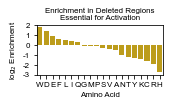

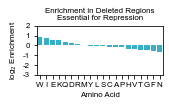

In [69]:
def compute_freq(tilelist, seqlist, effect):
    if effect == 'Act':
        newseqlist = []
        for t, s in zip(tilelist, seqlist):
            if t not in ['Q9J3N2_006', 'F5HIC6_025']:
                newseqlist.append(s)
        seqlist = ''.join(newseqlist)
    elif effect == 'Rep':
        seqlist = ''.join(seqlist)
    resDict = {'A':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 'H':0, 'I':0, 'K':0, 'L':0,
               'M':0, 'N':0, 'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'V':0, 'W':0, 'Y':0}
    resorder = ['G', 'A', 'V', 'L', 'M', 'I', 'F', 'Y', 'W', 'K', 'R', 'H', 'D', 'E', 'S', 'T', 'C', 'N', 'Q', 'P']

    total = 0
    for s in seqlist:
        resDict[s] += 1
        total += 1
    res = []
    freq = []
    for k in resorder:
        res.append(k)
        freq.append(resDict[k]/total)

    hhvfreq = [0.0608, 0.0794, 0.0692, 0.101, 0.022, 0.0461, 0.0422, 0.0309, 0.0128, 0.0379,
               0.0718, 0.0273, 0.0477, 0.0502, 0.0749, 0.0651, 0.026, 0.0364, 0.0333, 0.0652]

    resDF = pd.DataFrame({'Residue':res, 'Deletion':freq, 'HHV':hhvfreq})
    resDF['Residual'] = np.log2(resDF['Deletion']/resDF['HHV'])
    return resDF

def plot_resfreq(tilelist, del_seq, effect, category):
    resDF = compute_freq(tilelist, del_seq, effect)
    colorDict = {'Act':'#D7AC00', 'Rep':'#23BEDB'}
    labelDict = {'Act':'Activation', 'Rep':'Repression'}
        
    plt.figure(figsize=(2.4, 1.5))
    sns.barplot(data=resDF.sort_values(by=['Residual'], ascending=False), x='Residue', y='Residual', color=colorDict[effect])
    plt.title('Enrichment in Deleted Regions\nEssential for %s' % labelDict[effect], fontsize=8)
    plt.ylabel('log$_2$ Enrichment')
    plt.ylim([-3, 2])
    plt.yticks([-3, -2, -1, 0, 1, 2], [-3, -2, -1, 0, 1, 2])
    plt.xlabel('Amino Acid')
    plt.tight_layout()
    plt.savefig('../Individual Figure Panels/Figure 5/deletion_freq_enrichment_over_HHV_background_eff-%s_cat-%s_vertical.png' % (effect, category), dpi=1200)

plot_resfreq(Ab_nonext[0], Ab_nonext[1], 'Act', 'breaking')
plot_resfreq(Rb_nonext[0], Rb_nonext[1], 'Rep', 'breaking')

#### Barplots featured in Fig. 5F & 5G

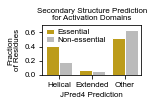

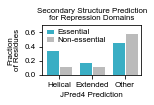

In [68]:
jpred4 = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/jpred4_results_summarized.csv').drop(columns='Protein Sequence')
maxtile = pd.read_csv('../Supplemental Tables - CSV/HHV-perturbation/HHV-perturb_max-tiles.csv')
jpred4 = pd.merge(jpred4, maxtile[['Tile ID', 'Tile Start', 'Tile End']], on='Tile ID', how='left')

def struct_analysis(df, tilelist, seqlist, startlist, endlist):
    structdict = {df.loc[i, 'Tile ID']:[df.loc[i, 'Structure'], df.loc[i, 'Tile Start'], df.loc[i, 'Tile End']] for i in range(len(df))}
    full_counts = [0, 0, 0, 0]
    ess_counts = [0, 0, 0, 0]
    
    for t, q, s, e in zip(tilelist, seqlist, startlist, endlist):
#         if (t == 'Q9J3N2_006') | (t == 'F5HIC6_025'):
#             continue
        pred = ''.join([p for p in list(structdict[t][0]) if p in ['H', 'E', '-']])
        i = int(s - structdict[t][1])
        j = int(e - structdict[t][1]) + 1
        k = pred[i:j]
        feat = ['H', 'E', '-']
        for l in range(len(full_counts)):
            if l == 3:
                full_counts[3] += len(pred)
                ess_counts[3] += len(k)
            else:
                full_counts[l] += pred.count(feat[l])
                ess_counts[l] += k.count(feat[l])
        
    df2 = pd.DataFrame({'Count':['Helical', 'Extended', 'Other'],
                        'Essential':ess_counts[:-1],
                        'Full':full_counts[:-1]})
    df2['Full'] = df2['Full'] - df2['Essential']
    df2['Essential Fraction'] = df2['Essential']/ess_counts[-1]
    df2['Full Fraction'] = df2['Full']/full_counts[-1]
#     print(df2)
    return df2
    

def plot_struct_bias(df, effect):
    if effect == 'Activation':
        colors = ['#D7AC00', '#BBBBBB']

    else:
        colors = ['#23BEDB', '#BBBBBB']
    df = df[['Count', 'Essential Fraction', 'Full Fraction']].rename(columns={'Count':'Prediction', 'Essential Fraction':'Essential', 'Full Fraction':'Non-essential'})
    df = pd.melt(df, id_vars='Prediction', value_vars=['Essential', 'Non-essential'], var_name='Fraction')
    plt.figure(figsize=(2.1, 1.5))
    sns.barplot(data=df, x='Prediction', y='value', hue='Fraction', palette=sns.color_palette(colors), edgecolor='white')
    plt.title('Secondary Structure Prediction\nfor %s Domains' % effect, fontsize=8)
    plt.ylabel('Fraction\nof Residues')
    plt.yticks([0.0, 0.2, 0.4, 0.6])
    plt.ylim(0,0.7)
    plt.xlabel('JPred4 Prediction')
    plt.legend(frameon=False, handlelength=1, labelspacing=0.1, handletextpad=0.5, borderpad=-0.1, fontsize=8)
    plt.tight_layout()
    plt.savefig('../Individual Figure Panels/Figure 5/HHV_%s_essential-region_breaking-only_JPred4-secondary-structure.png' % effect, dpi=1200)
    
dfA_str = struct_analysis(jpred4, Ab_nonext[0], Ab_nonext[1], Ab_nonext[2], Ab_nonext[3])
dfR_str = struct_analysis(jpred4, Rb_nonext[0], Rb_nonext[1], Rb_nonext[2], Rb_nonext[3])

plot_struct_bias(dfA_str, 'Activation')
plot_struct_bias(dfR_str, 'Repression')